# Recording BOLD signals

Download the Jupyter notebook : [BoldMonitoring.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/BoldMonitoring.ipynb)

This notebook demonstrates the usage of the BOLD monitoring extension. It has to be explicitly imported:

In [1]:
from ANNarchy import *
from ANNarchy.extensions.bold import *

ANNarchy 4.7 (4.7.1b) on darwin (posix).


## Background

ANNarchy pre-implements some model variants of the BOLD models presented in Stephan et al. (2007) which are variations of the Balloon Model originally designed by Buxton et al. (1998). The four balloon variants model pre-implemented in ANNarchy follow the naming scheme of Stephan et al. (2007). The model name starts with *balloon_* followed by either *C* (i. e. classical coefficient) or *R* (i. e. revised coefficient) and then followed by either *N* which means non-linear BOLD equation or *L* which means linear bold equation.

We only provide here the equations without much explanations, for more details please refer to the literature:

>  Buxton, R. B., Wong, E. C., and Frank, L. R. (1998). Dynamics of blood flow and oxygenation changes during brain activation: the balloon model. Magnetic resonance in medicine 39, 855–864. doi:10.1002/mrm.1910390602

>  Friston et al. (2000). Nonlinear responses in fMRI: the balloon model, volterra kernels, and other hemodynamics. NeuroImage 12, 466–477

>  Buxton et al. (2004). Modeling the hemodynamic response to brain activation. Neuroimage 23, S220–S233. doi:10.1016/j.neuroimage.2004.07.013

>  Stephan et al. (2007). Comparing hemodynamic models with DCM. Neuroimage 38, 387–401. doi:10.1016/j.neuroimage.2007.07.040

>  Maith et al. (2021) A computational model-based analysis of basal ganglia pathway changes in Parkinson’s disease inferred from resting-state fMRI. European Journal of Neuroscience. 2021; 53: 2278– 2295. doi:10.1111/ejn.14868 


## Single input Balloon model

This script shows a simple example for the application of one of the default models (the *balloon_RN* model) on a simple network. The *balloon_RN* model is described by the following equations:

$$
    \tau \cdot \frac{ds}{dt} = \phi \cdot I_\text{CBF} - \kappa \cdot s - \gamma \cdot (f_{in} - 1)
$$

$$
    \frac{df_{in}}{dt} = s
$$

$$
    E = 1 - (1 - E_{0})^{ \frac{1}{f_{in}} }
$$

$$
    \tau \cdot \frac{dv}{dt} = \frac{1}{\tau_0} \cdot (f_{in} - f_{out})
$$

$$
    f_{out} = v^{\frac{1}{\alpha}}
$$

$$
    \tau \cdot \frac{dq}{dt} = \frac{1}{\tau_0} \cdot ( f_{in} \cdot \frac{E}{E_0} - \frac{q}{v} \cdot f_{out} )
$$

with revised coefficients and non-linear bold equation:

$$k_1            = 4.3 \, v_0 \, E_0 \, \text{TE}$$

$$k_2            = \epsilon \, r_0 \, E_0 \, \text{TE}$$

$$k_3            = 1 - \epsilon$$

$$
    BOLD = v_0 \cdot ( k_1 \cdot (1-q) + k_2 \cdot (1 - \dfrac{q}{v}) + k_3 \cdot (1 - v) )
$$

There are two important variables in that model: `BOLD` which is the output of the model and `I_CBF` which is the input signal, reflecting the mean firing rate of the input populations.

As the BOLD model reflects the change of activity levels in the recorded area, we will implement the following experiment. We record from two populations with 100 Izhikevich neurons each. After a short period of time we raise the activity level of one population for a fixed time window. For simplicity, we do not use connections between the neurons but simply increase the noise term in the Izhikevich model. This should lead to a noticeable BOLD signal.

### Populations

We first create two populations of Izhikevich neurons:

In [2]:
clear()

pop0 = Population(100, neuron=Izhikevich)
pop1 = Population(100, neuron=Izhikevich)

As we will not have any connections between the neurons, we need to increase the noise to create some baseline activity:

In [3]:
# Set noise to create some baseline activity
pop0.noise = 5.0; pop1.noise = 5.0

The mean firing rate of the neurons will be used as an input to the BOLD model. This need to be activated explicitly as the computation of this value is quite expensive. In our example, the mean firing rate should be computed across a time window of 100 ms. The resulting value will be stored in the `r` attribute of the populations and can be easily recorded.

In [4]:
# Compute mean firing rate in Hz on 100ms window
pop0.compute_firing_rate(window=100.0)
pop1.compute_firing_rate(window=100.0)

# Record the mean firing rate
mon_pop0 = Monitor(pop0, ["r"], start=False)
mon_pop1 = Monitor(pop1, ["r"], start=False)

### BOLD Monitor definition

The BOLD monitor expects a list of populations which we want to record (in our case `pop0` and `pop1`). A BOLD model should be specified, here we take `balloon_RN` which is the default. We then specify the mapping from the population variable that should influence the BOLD signal, in our case the mean firing rate `r`, to the input variable of the BOLD model `I_CBF`. 

The mean firing rate is normalized over a time window of 2000 ms and we record both input and output signals:

In [5]:
m_bold = BoldMonitor(
    
    populations = [pop0, pop1], # recorded populations
    
    bold_model = balloon_RN(), # BOLD model to use (default is balloon_RN)
    
    mapping = {'I_CBF': 'r'}, # mapping from pop.r to I_CBF
    
    normalize_input = 2000,  # time window to compute baseline.
    
    recorded_variables = ["I_CBF", "BOLD"]  # variables to be recorded
)

Now we can compile and initialize the network:

In [6]:
compile()

Compiling ...  OK 


### Simulation

We first simulate 1 second biological time to ensure that the network reaches a stable firing rate:

In [7]:
# Ramp up time
simulate(1000)

We then enable the recording of all monitors:

In [8]:
# Start recording
mon_pop0.start()
mon_pop1.start()
m_bold.start()

We simulate for 5 seconds with lower noise and we increase the noise in `pop0` for 5 seconds before decreasing it again:

In [9]:
# We manipulate the noise for the half of the neurons
simulate(5000)      # 5s with low noise
pop0.noise = 7.5
simulate(5000)      # 5s with higher noise (one population)
pop0.noise = 5
simulate(10000)     # 10s with low noise

# Retrieve the recordings
mean_fr1 = np.mean(mon_pop0.get("r"), axis=1)
mean_fr2 = np.mean(mon_pop1.get("r"), axis=1)

input_data = m_bold.get("I_CBF")
bold_data = m_bold.get("BOLD")

### Evaluation

We can now plot:

* the mean firing rate in the input populations.
* the recorded activity `I` which serves as an input to the BOLD model.
* the resulting BOLD signal.

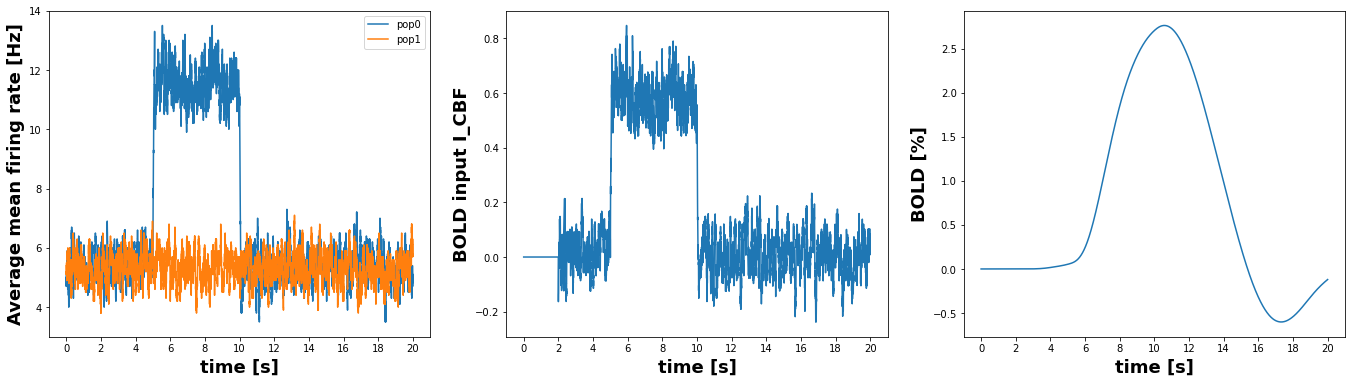

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])

ax1.plot(mean_fr1, label="pop0")
ax1.plot(mean_fr2, label="pop1")
plt.legend()
ax1.set_ylabel("Average mean firing rate [Hz]", fontweight="bold", fontsize=18)

# BOLD input signal
ax2 = plt.subplot(grid[0, 1])

ax2.plot(input_data)
ax2.set_ylabel("BOLD input I_CBF", fontweight="bold", fontsize=18)

# BOLD output signal
ax3 = plt.subplot(grid[0, 2])

ax3.plot(bold_data*100.0)
ax3.set_ylabel("BOLD [%]", fontweight="bold", fontsize=18)

# x-axis labels as seconds
for ax in [ax1, ax2, ax3]:
    ax.set_xticks(np.arange(0,21,2)*1000)
    ax.set_xticklabels(np.arange(0,21,2))
    ax.set_xlabel("time [s]", fontweight="bold", fontsize=18)

plt.show()

## Davis model

Let's now demonstrate how to define a custom BOLD model. The default Ballon model is defined by the following code:

```python
balloon_RN = BoldModel(
    parameters = """
        phi       = 1.0         ;   kappa     = 1/1.54
        gamma     = 1/2.46      ;   E_0       = 0.34
        tau       = 0.98        ;   alpha     = 0.33
        V_0       = 0.02        ;   v_0       = 40.3
        TE        = 40/1000.    ;   epsilon   = 1.43
        r_0       = 25.         ;   second    = 1000.0
    """,
    equations = """
        # CBF input
        I_CBF          = sum(I_CBF)       
        ds/dt          = (phi * I_CBF - kappa * s - gamma * (f_in - 1))/second  
        df_in/dt       = s / second                                                : init=1, min=0.01

        # Balloon model
        E              = 1 - (1 - E_0)**(1 / f_in)                                 : init=0.3424
        dq/dt          = (f_in * E / E_0 - (q / v) * f_out)/(tau*second)           : init=1, min=0.01
        dv/dt          = (f_in - f_out)/(tau*second)                               : init=1, min=0.01
        f_out          = v**(1 / alpha)                                            : init=1, min=0.01

        # Revised coefficients
        k_1            = 4.3 * v_0 * E_0 * TE
        k_2            = epsilon * r_0 * E_0 * TE
        k_3            = 1.0 - epsilon

        # Non-linear BOLD equation
        BOLD           = V_0 * (k_1 * (1 - q) + k_2 * (1 - (q / v)) + k_3 * (1 - v))
    """,
    inputs=['I_CBF']
)
```

It is very similar to the interface of a Neuron model, with parameters and equations defined in two multi-line strings. The input signal `I_CBF` has to be explicitly defined in the `inputs` argument to help the BOLD monitor create the mapping. 

To demonstrate how to create a custom BOLD model, let's suppose we want a model that computes both the BOLD signal of the Balloon model and the one of the Davis model:

> Davis, T. L., Kwong, K. K., Weisskoff, R. M., and Rosen, B. R. (1998). Calibrated functional MRI: mapping the dynamics of oxidative metabolism. Proceedings of the National Academy of Sciences 95, 1834–1839

Without going into too many details, the Davis model computes the BOLD signal directly using `f_in` and `E`, without introducing a differential equation for the BOLD signal. Its implementation using the BOLD model would be:

```python
DavisModel = BoldModel(
    parameters = """
        second = 1000.0
        
        phi    = 1.0    # Friston et al. (2000)
        kappa  = 1/1.54
        gamma  = 1/2.46
        E_0    = 0.34
        
        M      = 0.149   # Griffeth & Buxton (2011)
        alpha  = 0.14
        beta   = 0.91
    """,
    equations = """
        # CBF-driving input as in Friston et al. (2000)
        I_CBF    = sum(I_CBF)                                             : init=0
        ds/dt    = (phi * I_CBF - kappa * s - gamma * (f_in - 1))/second  : init=0
        df_in/dt = s  / second                                            : init=1, min=0.01
    ​
        # Using part of the Balloon model to calculate r (normalized CMRO2) as in Buxton et al. (2004)
        E        = 1 - (1 - E_0)**(1 / f_in)                              : init=0.34
        r        = f_in * E / E_0
        
        # Davis model
        BOLD     = M * (1 - f_in**alpha * (r / f_in)**beta)               : init=0
    """,
    inputs=['I_CBF']
)
```

Note that we could simply define two BOLD monitors using different models, but let's create a complex model that does both for the sake of demonstration.

Let's first redefine the populations of the previous section:


In [11]:
clear()

# Two populations of 100 izhikevich neurons
pop0 = Population(100, neuron=Izhikevich)
pop1 = Population(100, neuron=Izhikevich)

# Set noise to create some baseline activity
pop0.noise = 5.0; pop1.noise = 5.0

# Compute mean firing rate in Hz on 100ms window
pop0.compute_firing_rate(window=100.0)
pop1.compute_firing_rate(window=100.0)

# Create required monitors
mon_pop0 = Monitor(pop0, ["r"], start=False)
mon_pop1 = Monitor(pop1, ["r"], start=False)

We can now create a hybrid model computing both the Balloon RN model of Stephan et al. (2007) and the Davis model:

In [12]:
balloon_Davis = BoldModel(
    parameters = """
        phi       = 1.0         ;   kappa     = 1/1.54
        gamma     = 1/2.46      ;   E_0       = 0.34
        tau       = 0.98        ;   alpha     = 0.33
        V_0       = 0.02        ;   v_0       = 40.3
        TE        = 40/1000.    ;   epsilon   = 1.43
        r_0       = 25.         ;   second    = 1000.0
        M         = 0.062       ;   alpha2    = 0.14
        beta      = 0.91
    """,
    equations = """
        # CBF input
        I_CBF          = sum(I_CBF)       
        ds/dt          = (phi * I_CBF - kappa * s - gamma * (f_in - 1))/second  
        df_in/dt       = s / second                                                : init=1, min=0.01

        # Balloon model
        E              = 1 - (1 - E_0)**(1 / f_in)                                 : init=0.3424
        dq/dt          = (f_in * E / E_0 - (q / v) * f_out)/(tau*second)           : init=1, min=0.01
        dv/dt          = (f_in - f_out)/(tau*second)                               : init=1, min=0.01
        f_out          = v**(1 / alpha)                                            : init=1, min=0.01

        # Revised coefficients
        k_1            = 4.3 * v_0 * E_0 * TE
        k_2            = epsilon * r_0 * E_0 * TE
        k_3            = 1.0 - epsilon

        # Non-linear BOLD equation
        BOLD           = V_0 * (k_1 * (1 - q) + k_2 * (1 - (q / v)) + k_3 * (1 - v))
        
        # Davis model
        r = f_in * E / E_0                                                         : init=1, min=0.01
        BOLD_Davis =  M * (1 - f_in**alpha2 * (r / f_in)**beta) 
    """,
    inputs=['I_CBF']
)

We now only need to pass that new object to the BOLD monitor, and specify that we want to record both `BOLD` and `BOLD_Davis`:

In [ ]:
m_bold = BoldMonitor(
    
    populations = [pop0, pop1],  
    
    bold_model = balloon_Davis,
    
    mapping={'I_CBF': 'r'},            
    
    normalize_input=2000, 
    
    recorded_variables=["I_CBF", "BOLD", "BOLD_Davis"]
)

compile()

Compiling ...  

We run the same simulation protocol and compare the two BOLD signals. Note that the value of `M` has been modified to give a similar amplitude to both signals:

In [ ]:
# Ramp up time
simulate(1000)

# Start recording
mon_pop0.start()
mon_pop1.start()
m_bold.start()

# we manipulate the noise for the half of the neurons
simulate(5000)      # 5s with low noise
pop0.noise = 7.5
simulate(5000)      # 5s with higher noise (one population)
pop0.noise = 5
simulate(10000)     # 10s with low noise

# retrieve the recordings
mean_fr1 = np.mean(mon_pop0.get("r"), axis=1)
mean_fr2 = np.mean(mon_pop1.get("r"), axis=1)

If_data = m_bold.get("I_CBF")
bold_data = m_bold.get("BOLD")
davis_data = m_bold.get("BOLD_Davis")

In [ ]:
plt.figure(figsize=(20,8))
grid = plt.GridSpec(1, 2, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])
ax1.plot(mean_fr1, label="pop0")
ax1.plot(mean_fr2, label="pop1")
plt.legend()
ax1.set_ylabel("Average firing rate [Hz]", fontweight="bold", fontsize=18)

# BOLD input signal as percent
ax2 = plt.subplot(grid[0, 1])
ax2.plot(bold_data*100.0, label="Balloon_RN")
ax2.plot(davis_data*100.0, label="Davis")
plt.legend()
ax2.set_ylabel("BOLD [%]", fontweight="bold", fontsize=18)

# x-axis labels as seconds
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0,21,2)*1000)
    ax.set_xticklabels(np.arange(0,21,2))
    ax.set_xlabel("time [s]", fontweight="bold", fontsize=18)

plt.show()